<a href="https://colab.research.google.com/github/fuyokmarble/MicroprocessorLab/blob/master/CreatingandTrainingNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Network**

**Member**
1. Arpanant Saeng-Xuto   62011096
2. Kanokporn Choosanguan 62011132
3. Kritjuhn Kaklai       62011268

In this notebook, we create a neural network `Model` class:

* Create a model by adding dense layers to it
* Layers have relu activation function except the output layer which has sigmoid activation
* Optimization algorithm would be gradient descent
* Also have a train method to perform the training. The training will be initialise parameters, forward prop, compute cost, backward prop and update parameters

## Helper Functions and Libraries

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

def relu(Z):
    R = np.maximum(0, Z)
    return R

def sigmoid(Z): 
    S = 1 / (1 + np.exp(-1 * Z))
    return S

def relu_derivative(Z):
    Z[Z >= 0] = 1
    Z[Z < 0]  = 0
    return Z

def sigmoid_derivative(Z):
    SD = sigmoid(Z) * (1 - sigmoid(Z))
    return SD

Declare functions of Sigmoid, Derivative of the Sigmoid, Rectified Linear Activation, and Derivative of the Rectified Linear Activation.


## NN Model

In [2]:
class Model():
    def __init__(self): #objects are created from the class and it allow the class to initialize the attributes of a class.
        self.layers = []
        self.L = 0 
        self.W = {} #Weights
        self.b = {} #Bias
        self.A = {} 
        self.Z = {} 
        self.dA = {}
        self.dZ = {}
        self.dW = {}
        self.db = {}
        self.cost = 0.
        self.m = 0
        self.lam = 0
        self.cost_history = []
        self.acc_history = []
        self.alpha_history = []
        self.alpha = 0.
        self.iterations = 0

    def add_layers(self, list_of_layers):
        self.layers = list_of_layers
        self.L = len(self.layers) - 1 # Number of layers excluding the input feature layer
    
    def init_params(self):
        for i in range(1, self.L + 1):
            self.W[str(i)] = np.random.randn(self.layers[i], self.layers[i - 1]) * np.sqrt(2. / self.layers[i - 1])
            self.b[str(i)] = np.zeros((self.layers[i], 1))
    
    def forward_prop(self, X):
        self.A['0'] = X
        
        for i in range(1, self.L + 1):
            self.Z[str(i)] = np.dot(self.W[str(i)], self.A[str(i - 1)]) + self.b[str(i)]
            if i == self.L:
                # Output layer, Sigmoid activation
                self.A[str(i)] = sigmoid(self.Z[str(i)])
            else:
                # Hidden layer, Relu activataion
                self.A[str(i)] = relu(self.Z[str(i)])
    
    def compute_cost(self, Y):
        self.cost = -1 * np.sum(np.multiply(Y, np.log(self.A[str(self.L)])) + np.multiply(1 - Y, np.log(1 - self.A[str(self.L)]))) / self.m 
        
        if self.lam != 0:
            reg = (self.lam / (2 * self.m))
            for i in range(1, self.L + 1):
                reg += np.sum(np.dot(self.W[str(i)], self.W[str(i)].T))
            self.cost += reg
            
        self.cost_history.append(self.cost)
    
    def backward_prop(self, Y):
        # We need dA[str(L)] to start the backward prop computation
        self.dA[str(self.L)] = -1 * (np.divide(Y, self.A[str(self.L)]) - np.divide(1 - Y, 1 - self.A[str(self.L)]))
        self.dZ[str(self.L)] = np.multiply(self.dA[str(self.L)], sigmoid_derivative(self.Z[str(self.L)]))
        self.dW[str(self.L)] = np.dot(self.dZ[str(self.L)], self.A[str(self.L - 1)].T) / self.m + (self.lam/self.m) * self.W[str(self.L)]
        self.db[str(self.L)] = np.sum(self.dZ[str(self.L)], axis = 1, keepdims = True) / self.m
        self.dA[str(self.L - 1)] = np.dot(self.W[str(self.L)].T, self.dZ[str(self.L)])
            
        for i in reversed(range(1, self.L)):

            self.dZ[str(i)] = np.multiply(self.dA[str(i)], relu_derivative(self.Z[str(i)]))
            self.dW[str(i)] = np.dot(self.dZ[str(i)], self.A[str(i - 1)].T) / self.m + (self.lam/self.m) * self.W[str(i)]
            self.db[str(i)] = np.sum(self.dZ[str(i)], axis = 1, keepdims = True) / self.m
            self.dA[str(i - 1)] = np.dot(self.W[str(i)].T, self.dZ[str(i)])
    
    def update_params(self):
        for i in range(1, self.L + 1):
            self.W[str(i)] = self.W[str(i)] - self.alpha * self.dW[str(i)]
            self.b[str(i)] = self.b[str(i)] - self.alpha * self.db[str(i)]
    
    def train(self, X, Y, iterations = 10, 
        alpha = 0.001, decay = True, decay_iter = 5, decay_rate = 0.9, stop_decay_counter = 100,
        verbose = True, lam = 0):
        
        self.m = Y.shape[1]
        self.alpha = alpha
        self.iterations = iterations
        self.lam = lam
        
        # initialize parameters
        self.init_params()

        for i in range(iterations):
            # forward prop
            self.forward_prop(X)
            # compute cost
            self.compute_cost(Y)
            # backward prop
            self.backward_prop(Y)
            # update params
            self.update_params()
            # evaluate
            self.acc_history.append(self.evaluate(X, Y, in_training = True))
            # save alpha
            self.alpha_history.append(self.alpha)
            # learning rate decay
            if decay and stop_decay_counter > 0 and i % decay_iter == 0:
                self.alpha = decay_rate * self.alpha
                stop_decay_counter -= 1
            # display cost per iteration
            if verbose:
                print('Cost after {} iterations: {}'.format(i, self.cost))
    
    def predict(self, X, in_training = False):
        if in_training == False:
            self.forward_prop(X)
            
        preds = self.A[str(self.L)] >= 0.5
        preds = np.squeeze(preds)
        return preds
        
    def evaluate(self, X, Y, in_training = False):
        examples = X.shape[1]
        
        pred = self.predict(X, in_training = in_training)
        pred = pred.reshape(1, examples)
        diff = np.sum(abs(pred - Y))
        acc = (examples - np.sum(diff)) / examples
        return acc
    
    def plot_cost(self):
        plt.plot(range(self.iterations), self.cost_history, color = 'b')
        plt.show()
    
    def plot_acc(self):
        plt.plot(range(self.iterations), self.acc_history, color = 'r')
        plt.show()
    
    def plot_alpha(self):
        plt.plot(range(self.iterations), self.alpha_history, color = 'g')
        plt.show()

## Testing the Model

In [3]:
m = Model()
m.add_layers([2, 2, 1])
X = np.array([
    [1., 0., 0., 0., -10., 9.],
    [0., 1., 0., -6., -4., -1.]])
Y = np.array([1, 1, 1, 0, 0, 1])
Y = Y.reshape(1, 6)

m.train(X, Y, iterations = 50, alpha = 0.1, verbose = False)
#m.train(X, Y, iterations = 50, alpha = 0.1, verbose = True)

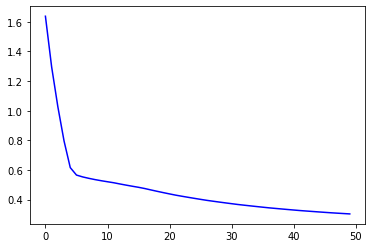

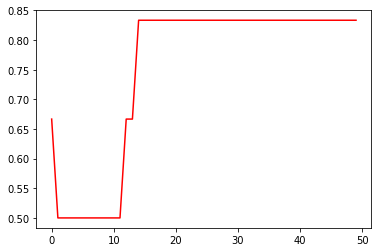

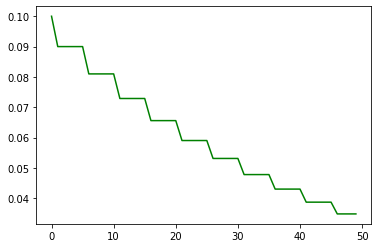

In [4]:
m.plot_cost()
m.plot_acc()
m.plot_alpha()

In [5]:
print(m.evaluate(X, Y))

0.8333333333333334


In [6]:
print(m.predict(X))

[ True  True  True False  True  True]


## Haberman Survival Dataset

Dataset contains cases from study conducted on the survival of patients who had undergone surgery for breast cancer. Get the data and its description from UCI's [Machine Learning Repo](https://archive.ics.uci.edu/ml/datasets/Haberman%27s+Survival).

In [7]:
import pandas as pd

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data', sep = ',', header = None)
data.head()

,0,1,2,3
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


We have three features and one class. 1 means that the patient survived for 5 years or longer and 2 means that the patient died within 5 years.

In [8]:
X_train = data.iloc[:,:-1]
Y_train = data.iloc[:, -1]

X_train = np.array(X_train)
Y_train = np.array(Y_train)
Y_train = Y_train.reshape(Y_train.shape[0], 1)

print(X_train.shape)
print(Y_train.shape)

(306, 3)
(306, 1)


In [9]:
mean = np.mean(X_train, axis = 0)
variance = np.var(X_train, axis = 0)

X_train = np.divide((X_train - mean), variance)

In [10]:
print(X_train[0])

[-0.19304484  0.10899327 -0.05873476]


In [11]:
Y_train = Y_train - 1
# Changing label 1 to 0 and label 2 to 1

In [12]:
# Split the data into test and train sets
from sklearn.utils import shuffle

X_train, Y_train = shuffle(X_train, Y_train)

X_test = X_train[250:,:]
Y_test = Y_train[250:,:]

X_train_ = X_train[:250,:]
Y_train_ = Y_train[:250,:]

print(X_train_.shape)
print(Y_train_.shape)
print(X_test.shape)
print(Y_test.shape)

(250, 3)
(250, 1)
(56, 3)
(56, 1)


In [13]:
X_train_ = X_train_.reshape(3, 250)
Y_train_ = Y_train_.reshape(1, 250)
X_test  = X_test.reshape(3, 56)
Y_test  = Y_test.reshape(1, 56)

##1)

In [14]:
m = Model()
m.add_layers([3, 16, 16, 16, 1]) #3 hidden layers
m.train(X_train_, Y_train_, alpha = 0.9, decay_rate = 0.98, decay_iter = 10, stop_decay_counter = 100, iterations = 500, verbose = False, lam = 2)

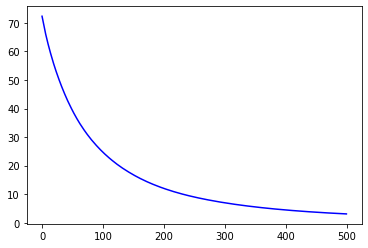

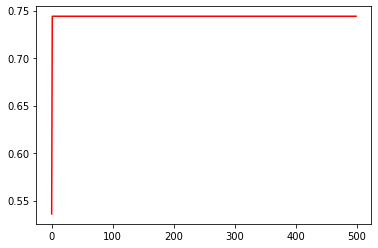

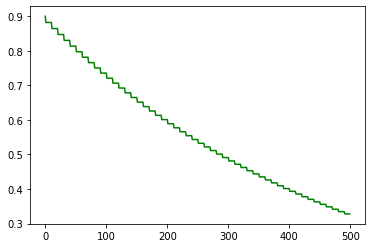

Test set acc =  0.6964285714285714


In [15]:
m.plot_cost()
m.plot_acc()
m.plot_alpha()
print('Test set acc = ', m.evaluate(X_test, Y_test))

#2) changing the value of alpha

In [16]:
m = Model()
m.add_layers([3, 16, 16, 16, 1])
m.train(X_train_, Y_train_, alpha = 0.0001, decay_rate = 0.98, decay_iter = 10, stop_decay_counter = 100, iterations = 500, verbose = False, lam = 2)

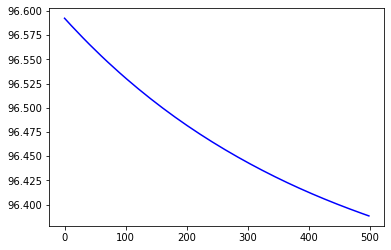

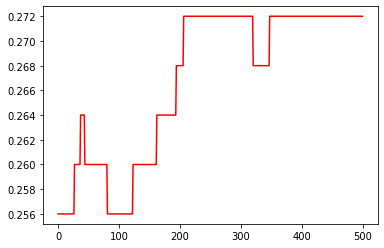

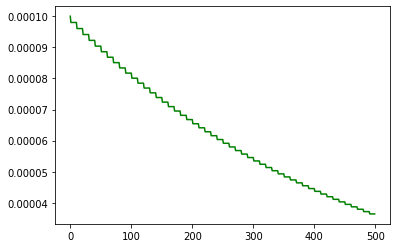

Test set acc =  0.2857142857142857


In [17]:
m.plot_cost()
m.plot_acc()
m.plot_alpha()
print('Test set acc = ', m.evaluate(X_test, Y_test))

#3) changing the value of decay_rate

In [18]:
m = Model()
m.add_layers([3, 16, 16, 16, 1])
m.train(X_train_, Y_train_, alpha = 0.9, decay_rate = 0.01, decay_iter = 10, stop_decay_counter = 100, iterations = 500, verbose = False, lam = 2)

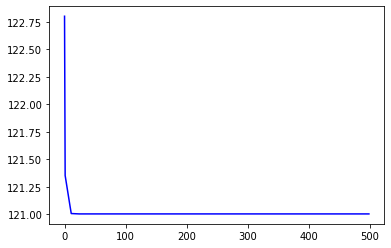

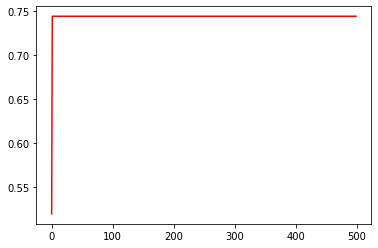

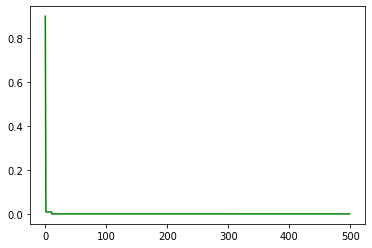

Test set acc =  0.6964285714285714


In [19]:
m.plot_cost()
m.plot_acc() 
m.plot_alpha()
print('Test set acc = ', m.evaluate(X_test, Y_test))

#4) changing the value of decay_iter

In [20]:
m = Model()
m.add_layers([3, 16, 16, 16, 1])
m.train(X_train_, Y_train_, alpha = 0.9, decay_rate = 0.98, decay_iter = 70, stop_decay_counter = 100, iterations = 500, verbose = False, lam = 2)

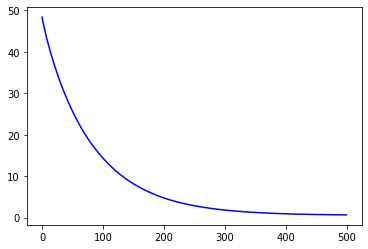

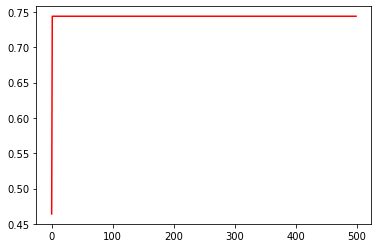

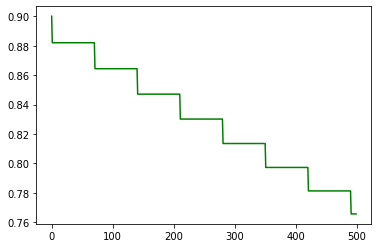

Test set acc =  0.6964285714285714


In [21]:
m.plot_cost()
m.plot_acc()
m.plot_alpha()
print('Test set acc = ', m.evaluate(X_test, Y_test))

#5) changing the value of stop_decay_counter

In [ ]:
m = Model()
m.add_layers([3, 16, 16, 16, 1])
m.train(X_train_, Y_train_, alpha = 0.9, decay_rate = 0.98, decay_iter = 10, stop_decay_counter = 10, iterations = 5000, verbose = False, lam = 2)

In [ ]:
m.plot_cost()
m.plot_acc()
m.plot_alpha()
print('Test set acc = ', m.evaluate(X_test, Y_test))

#6) changing the value of iterations

In [ ]:
m = Model()
m.add_layers([3, 16, 16, 16, 1])
m.train(X_train_, Y_train_, alpha = 0.9, decay_rate = 0.98, decay_iter = 10, stop_decay_counter = 100, iterations = 500, verbose = False, lam = 2)

In [ ]:
m.plot_cost()
m.plot_acc()
m.plot_alpha()
print('Test set acc = ', m.evaluate(X_test, Y_test))

#7) changing the value of lam

In [ ]:
m = Model()
m.add_layers([3, 16, 16, 16, 1])
m.train(X_train_, Y_train_, alpha = 0.9, decay_rate = 0.98, decay_iter = 10, stop_decay_counter = 100, iterations = 500, verbose = False, lam = 0)

In [ ]:
m.plot_cost()
m.plot_acc()
m.plot_alpha()
print('Test set acc = ', m.evaluate(X_test, Y_test))

#8) changing the value of 3 hidden layers

In [ ]:
m = Model()
m.add_layers([3, 4, 17, 5, 1])
m.train(X_train_, Y_train_, alpha = 0.9, decay_rate = 0.98, decay_iter = 10, stop_decay_counter = 100, iterations = 50, verbose = False, lam = 2)

In [ ]:
m.plot_cost()
m.plot_acc()
m.plot_alpha()
print('Test set acc = ', m.evaluate(X_test, Y_test))

#9) changing the values of 3 hidden layers, alpha, and decay_rate in the same time

In [ ]:
m = Model()
m.add_layers([3, 20, 17, 16, 1])
m.train(X_train_, Y_train_, alpha = 0.01, decay_rate = 0.99, decay_iter = 10, stop_decay_counter = 100, iterations = 50, verbose = False, lam = 2)

In [ ]:
m.plot_cost()
m.plot_acc() 
m.plot_alpha()
print('Test set acc = ', m.evaluate(X_test, Y_test))

#10) changing the values of 3 hidden layers, alpha, decay_rate, and lam

In [ ]:
m = Model() 
m.add_layers([3, 34, 20, 16, 1])
m.train(X_train_, Y_train_, alpha = 0.01, decay_rate = 0.9, decay_iter = 10, stop_decay_counter = 10, iterations = 50, verbose = False, lam = 0.1)

In [ ]:
m.plot_cost()
m.plot_acc()
m.plot_alpha() 
print('Test set acc = ', m.evaluate(X_test, Y_test))

# Conclusion

* If decay was alpha, after number of decay_iter iterations, the value will be alpha*decay_rate.
* The value of lam affect to fluctuation of graph.
* In the function 'def init_params(self)', there has 'np.random' that make the initial random each time we run result in unstable value.